# Virginia Tech Post-Graduation Reports

This project utilizes Virginia Tech's post-graduate salary reports, spanning the years 2004-2017, to analyze and visualize recent graduate data, such as number of grads, employment rate, and starting salaries.

This project is structured as follows:
1. Web scraping VT post-graduate reports using BeautifulSoup
2. Web scraping NACE starting salary data using BeautifulSoup
2. Data cleaning and merging using pandas
3. Visualizing top 20 majors, by various measures, using matplotlib
4. Visualizing starting salary trends by major and college using matplotlib
5. Final conclusions

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

## Web Scraping Salary Data
Every year, Virginia Tech sends out a survey to all recent graduates to gather employment data, including starting salaries, bonuses, and location of employment. These reports are published on Virginia Tech's career services website and are categorized by college (department). 

Since there are no downloadable files available, web scraping is needed to gather this data. Before we can start visualizing data from these reports, we'll have to pull this data off the web and clean it.

### Web Scraping VT post-graduate reports
First, let's define some functions to web scrape VT's post-graduate reports in order to obtain starting salary information for each college. <a href="https://db.career.vt.edu/scripts/PostGrad2006/Report/DetailReportSalaries.asp?College=03&Cohort=2016-2017&Majors=Y">Here's</a> what this data looks like for a specific college. As you can see, different columns have slightly different formats. We'll take advantage of this to retrieve data based on these respective html tags.

<b>Note:</b> Due to the volatility of small sample sizes, we'll only be analyzing data for majors with 50 or more graduates in a given year. 

In [2]:
#Each college is represented by a certain id in the grad report url 
college_keys = {'College of Agriculture and Life Sciences':'01',
                'College of Architecture and Urban Studies':'02',
                'Pamplin College of Business':'03',
                'College of Engineering':'05',
                'College of Liberal Arts and Human Sciences':'07',
                'College of Science':'08',
                'College of Natural Resources and Environment':'10'}

In [3]:
#Get report data for a given year
def parse_year_report(college, year):
    #Get relevant info from post-grad reports
    report = str(year-1) + '-' + str(year)
    vt_url = "https://db.career.vt.edu/scripts/PostGrad2006/Report/DetailReportSalaries.asp?College=" + college_keys[college] + "&Cohort=" + report + "&Majors=Y"
    response = requests.get(vt_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    find_majors = soup.find_all("td",attrs={'width':'25%','class':'text11','colspan':'2'})
    #Match majors list length to other columsn
    majors_list = [find_majors[i].text for i, major in enumerate(find_majors)]
    majors_list.insert(0, college)
    find_n_grads = soup.find_all("td",attrs={'align':'right','class':'darkgray11','width':'6%'})
    find_emp_rate = soup.find_all("td",attrs={'align':'right','class':'darkgray11','width':'9%'})
    #find_salaries_25 = soup.find_all("td",attrs={'align':'right','class':'darkgray11','width':'9%'})
    find_salaries_50 = soup.find_all("td",attrs={'align':'right','class':'maroon11text','bgcolor':'#E6F2E7'})
    find_salaries_75 = soup.find_all("td",attrs={'align':'right','class':'faded11text','width':'9%'})
    #Get salary numbers for each major found in the report 
    grad_info = []
    for i, major in enumerate(majors_list):
        major = majors_list[i]
        n_grads = find_n_grads[i*2].text
        emp_rate = find_emp_rate[i*2].text
        emp_rate = emp_rate.strip().replace('%','')
        salary_25 = find_emp_rate[(i*2)+1].text #salary_25 and emp_rate share all the same properties
        salary_25 = salary_25.strip().replace('$','').replace(',','')
        salary_50 = find_salaries_50[i].text
        salary_50 = salary_50.strip().replace('$','').replace(',','')
        salary_75 = find_salaries_75[i].text
        salary_75 = salary_75.strip().replace('$','').replace(',','')
        grad_info.append([major, year, n_grads, emp_rate, salary_25, salary_50, salary_75])
    grad_df = pd.DataFrame(grad_info, columns=['major','year','n_grads','emp_rate','salary_25','median_salary','salary_75'])
    grad_df[['n_grads','emp_rate','salary_25','median_salary','salary_75']] = grad_df[['n_grads','emp_rate','salary_25','median_salary','salary_75']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    #Only factor in reports with more than or equal to 50 grads and a median salary reported 
    final_df = grad_df[(grad_df['median_salary'] != None) & (grad_df['n_grads'] >= 50)] 
    final_df.reset_index(inplace=True, drop=True)
    return final_df

#Combine report data from all years and majors into one dataframe
def all_years_reports(college):
    grad_df_dict = {}
    for i in range(2004,2018): #go through all report years 
        grad_df_dict[i] = parse_year_report(college, i)
    college_df = pd.concat(grad_df_dict.values(), ignore_index=True)
    #Sort dataframe by year, then number of grads
    sorted_df = college_df.sort_values(['year', 'n_grads'], ascending=[False, False])
    sorted_df.reset_index(inplace=True, drop=True)
    return sorted_df

In [4]:
parse_year_report('Pamplin College of Business', 2017) #preview sample dataframe

major  year  n_grads  emp_rate  salary_25  \
0       Pamplin College of Business  2017     1007        74    49250.0   
1  Accounting & Information Systems  2017      154        68    53000.0   
2   Business Information Technology  2017      321        80    60000.0   
3                           Finance  2017      210        73    50000.0   
4  Hospitality & Tourism Management  2017       73        79    37250.0   
5                        Management  2017      103        65    38965.0   
6              Marketing Management  2017      142        66    40000.0   

   median_salary  salary_75  
0        59000.0    65000.0  
1        57500.0    60000.0  
2        65000.0    72500.0  
3        57000.0    65000.0  
4        43000.0    47625.0  
5        47500.0    55500.0  
6        46000.0    58000.0

This project mainly focuses on median starting salaries. To add an extra level of analysis, let's try to find the median national starting salaries for the same window of time so that we can eventually compare the VT numbers to the national average. We'll have to find these numbers somewhere on the web. 

### Web Scraping National Average Starting Salaries
Although I couldn't find <i>median</i> starting salaries, I did find <i>average</i> starting salaries which should at least provide a good enough comparison. We'll use <i>National Association of Colleges and Employers</i> data by web scraping their <a href="http://www.naceweb.org/job-market/compensation/salary-trends-through-salary-survey-a-historical-perspective-on-starting-salaries-for-new-college-graduates/">salary trend article</a>.

In [5]:
#Get average starting salary by year from NACE website 
salary_url = "http://www.naceweb.org/job-market/compensation/salary-trends-through-salary-survey-a-historical-perspective-on-starting-salaries-for-new-college-graduates/"
response = requests.get(salary_url)
soup = BeautifulSoup(response.content, 'html.parser')
get_grad_salaries = soup.find_all("tr")[45:57] 
avg_salaries = []
for salary in get_grad_salaries:
    get_year = salary.find_all("td")[0]
    get_amount = salary.find_all("td")[1]
    year = int(get_year.text)
    amount = get_amount.text
    sal = int(amount.replace('$','').replace(',',''))
    temp_df = pd.DataFrame([[year, sal]], columns=('Year','Salary'))
    avg_salaries.append([year, sal])

This report has starting salaries from 2004 to 2015 but is missing data for 2016 and 2017. After googling NACE data, I found the <a href="https://www.naceweb.org/job-market/compensation/average-starting-salary-for-class-of-2016-held-steady/">2016</a> and <a href="http://www.naceweb.org/job-market/compensation/early-data-show-gains-dips-in-starting-salaries/">2017</a> numbers that we can append to the current list. 

In [6]:
#Add new data to dataframe
avg_salaries.append([2016, 50359]) 
avg_salaries.append([2017, 51022])
avg_sal_df = pd.DataFrame(avg_salaries,columns=('Year','Salary'))

avg_sal_df.tail(10) #preview dataframe

Year  Salary
4   2008   49224
5   2009   48633
6   2010   48288
7   2011   51171
8   2012   44259
9   2013   45327
10  2014   48127
11  2015   50219
12  2016   50359
13  2017   51022

Now that we have Virginia Tech salary data and national starting salary averages for these same years, we can visualize this data and see what we insights we can make.

## Visualizing Report Data

Before we jump into starting salary trends, let's take a look at the most popular majors in 2017 and the majors with the highest median starting salary. 

### Visualizing Top 20 Majors, by Various Measures
Let's define a function that gets the top 20 majors, based on a specific column, or measure. We'll start by analyzing median starting salary. 

In [7]:
#Get top 20 dataframe for a specific measure/column
def top_20_df(measure, year): 
    #Combine reports for all majors based on year
    year_dict = {}
    for key in college_keys.keys():
        college_df = parse_year_report(key, year)
        college_df['college'] = key
        just_majors = college_df[~college_df['major'].isin(college_keys.keys())]
        year_dict[key] = just_majors
    combined_year_df = pd.concat(year_dict.values(), ignore_index=True)
    combined_year_df[measure] = combined_year_df[measure].astype(int)
    combined_year_df.sort_values(measure, inplace=True, ascending=False)
    top_20_majors = combined_year_df[:20]
    top_20_majors.reset_index(inplace=True, drop=True)
    return top_20_majors

In [8]:
top_20_df('median_salary', 2017) 

major  year  n_grads  emp_rate  salary_25  \
0                   Computer Science  2017      195      81.0    70000.0   
1             Electrical Engineering  2017      150      61.0    60375.0   
2               Computer Engineering  2017      119      73.0    65000.0   
3                        Mathematics  2017       78      39.0    48000.0   
4    Materials Science & Engineering  2017       80      39.0    60000.0   
5   Industrial & Systems Engineering  2017      149      82.0    60000.0   
6               Chemical Engineering  2017      100      68.0    60000.0   
7    Business Information Technology  2017      321      80.0    60000.0   
8             Mechanical Engineering  2017      416      62.0    60000.0   
9              Aerospace Engineering  2017      132      55.0    60000.0   
10             Building Construction  2017       56      94.0    58000.0   
11    Biological Systems Engineering  2017       66      50.0    44900.0   
12                 Civil Engineering  2017      199      67.0    55000.0   
13   Engineering Science & Mechanics  2017       57      50.0    51000.0   
14  Accounting & Information Systems  2017      154      68.0    53000.0   
15                           Finance  2017      210      73.0    50000.0   
16                        Management  2017      103      65.0    38965.0   
17                      Architecture  2017      100      55.0    43000.0   
18              Marketing Management  2017      142      66.0    40000.0   
19                         Economics  2017       61      58.0    35000.0   

    median_salary  salary_75                                    college  
0           78000   100000.0                     College of Engineering  
1           71500    74250.0                     College of Engineering  
2           71000    85500.0                     College of Engineering  
3           70000    75700.0                         College of Science  
4           67000    69750.0                     College of Engineering  
5           67000    72500.0                     College of Engineering  
6           66000    72500.0                     College of Engineering  
7           65000    72500.0                Pamplin College of Business  
8           65000    70000.0                     College of Engineering  
9           65000    70000.0                     College of Engineering  
10          62500    67000.0  College of Architecture and Urban Studies  
11          60000    67000.0                     College of Engineering  
12          60000    62100.0                     College of Engineering  
13          58515    65000.0                     College of Engineering  
14          57500    60000.0                Pamplin College of Business  
15          57000    65000.0                Pamplin College of Business  
16          47500    55500.0                Pamplin College of Business  
17          47000    49575.0  College of Architecture and Urban Studies  
18          46000    58000.0                Pamplin College of Business  
19          45500    51000.0                         College of Science

Unsurprisingly, the College of Engineering dominates the median salary top 20 list (Virginia Tech is a great engineering university after all). It will be interesting to visualize a top 20 list for any given measure, including median starting salary. We'll develop a function to create a horizontal bar graph for the top 20 of any given measure, for any given year. 

In [9]:
#Define format for graphing different measures 
def horizontal_bar_by_college(measure, year):
    top_20_measure = top_20_df(measure, year)
    #Reverse order for plotting on y-axis
    top_20_measure.sort_values(measure,inplace=True, ascending=True)
    top_20_measure.reset_index(inplace=True, drop=True)
    #Assign bar color to each department
    map_college_colors = {'College of Engineering': (60/255, 110/255, 210/255),
                           'Pamplin College of Business': (102/255, 0, 0),
                           'College of Science': (0, 120/255, 0),
                           'College of Liberal Arts and Human Sciences': (250/255, 80/255, 90/255),
                           'College of Agriculture and Life Sciences': (220/255, 138/255, 0),
                           'College of Architecture and Urban Studies': (153/255, 51/255, 255/255)}
    top_20_colleges = top_20_measure['college'].map(map_college_colors)
    #Format chart
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    yticks=np.arange(1,21,1)
    ax.barh(yticks, top_20_measure[measure], height=0.7, align='center', color=top_20_colleges)
    ax.set_ylim(0.5,20.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    max_val = top_20_measure[measure].max()
    #Experiment with chart to find scalable offset values for labels
    legend_offset = max_val*0.85
    major_offset = max_val/140
    label_offset = major_offset/2
    rank_offset = -(max_val/350)
    if measure == 'median_salary':
        ax.set_xlim(0, max_val)
    for i, major in top_20_measure['major'].iteritems():
        ax.text(major_offset, i+1, major, va='center', weight='bold', color='w', fontsize=8.5)
        ax.text(top_20_measure[measure][i]+label_offset, i+1, top_20_measure[measure][i], va='center', ha='left', fontsize=8)
        ax.text(rank_offset, i+1, 20-i, ha='right', va='center', fontsize=8.5, weight='bold')
    ax.get_xaxis().set_visible(False)
    ax.set_yticklabels(np.arange(20,0,-1))
    ax.set_yticks([])
    for index, (key, value) in enumerate(map_college_colors.items()):
        ax.scatter(legend_offset, (index/1.6)+1, c=value)
        ax.text(legend_offset*1.013, (index/1.6)+0.98, key, fontsize=7, va='center')
    return top_20_measure

Now that we developed a function to visualize any top 20 list, let's start by seeing the most popular majors among 2017 graduates.

Text(0.5,1,'Top 20 Majors, by # of 2017 Graduates')

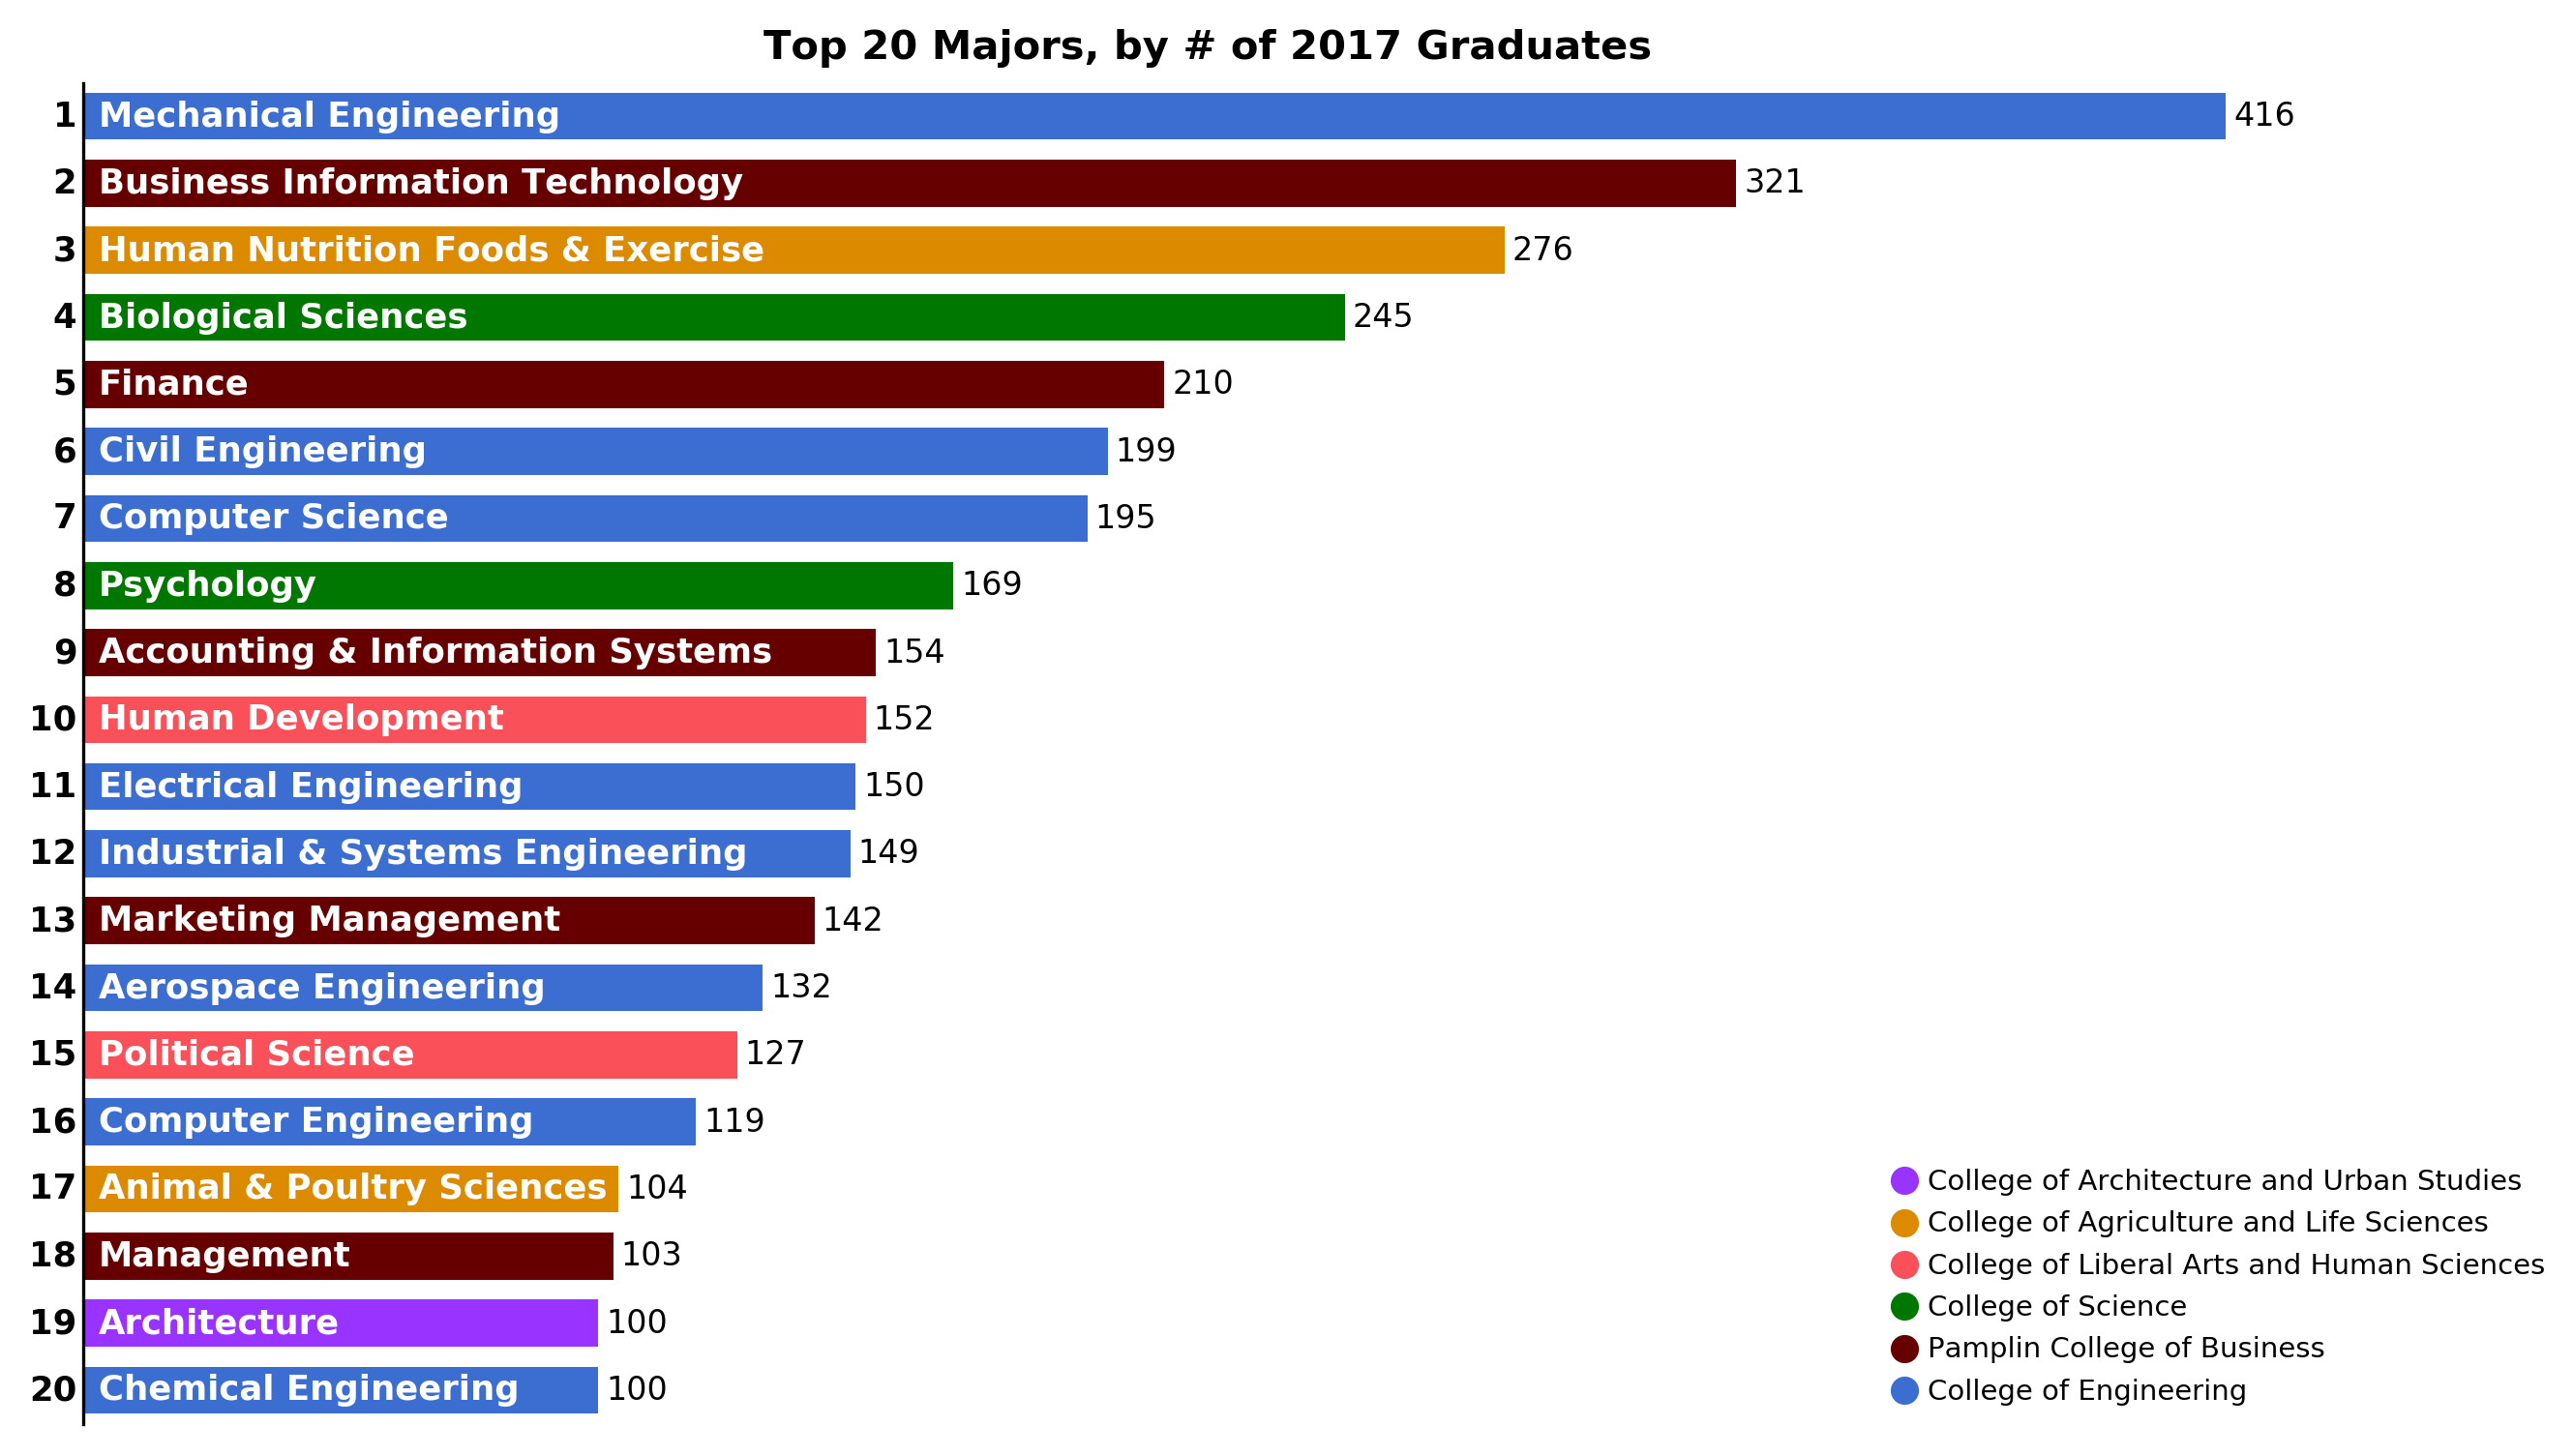

In [10]:
horizontal_bar_by_college('n_grads', 2017)
plt.title('Top 20 Majors, by # of 2017 Graduates', fontsize=10, weight='bold')

This top 20 list is pretty diverse, with four different department being represented in the top four majors and all departments being represented in this top 20 list. Let's see that what the most popular majors were among 2004 graduates so we can see how Virginia Tech has changed over the years. 

Text(0.5,1,'Top 20 Majors, by # of 2004 Graduates')

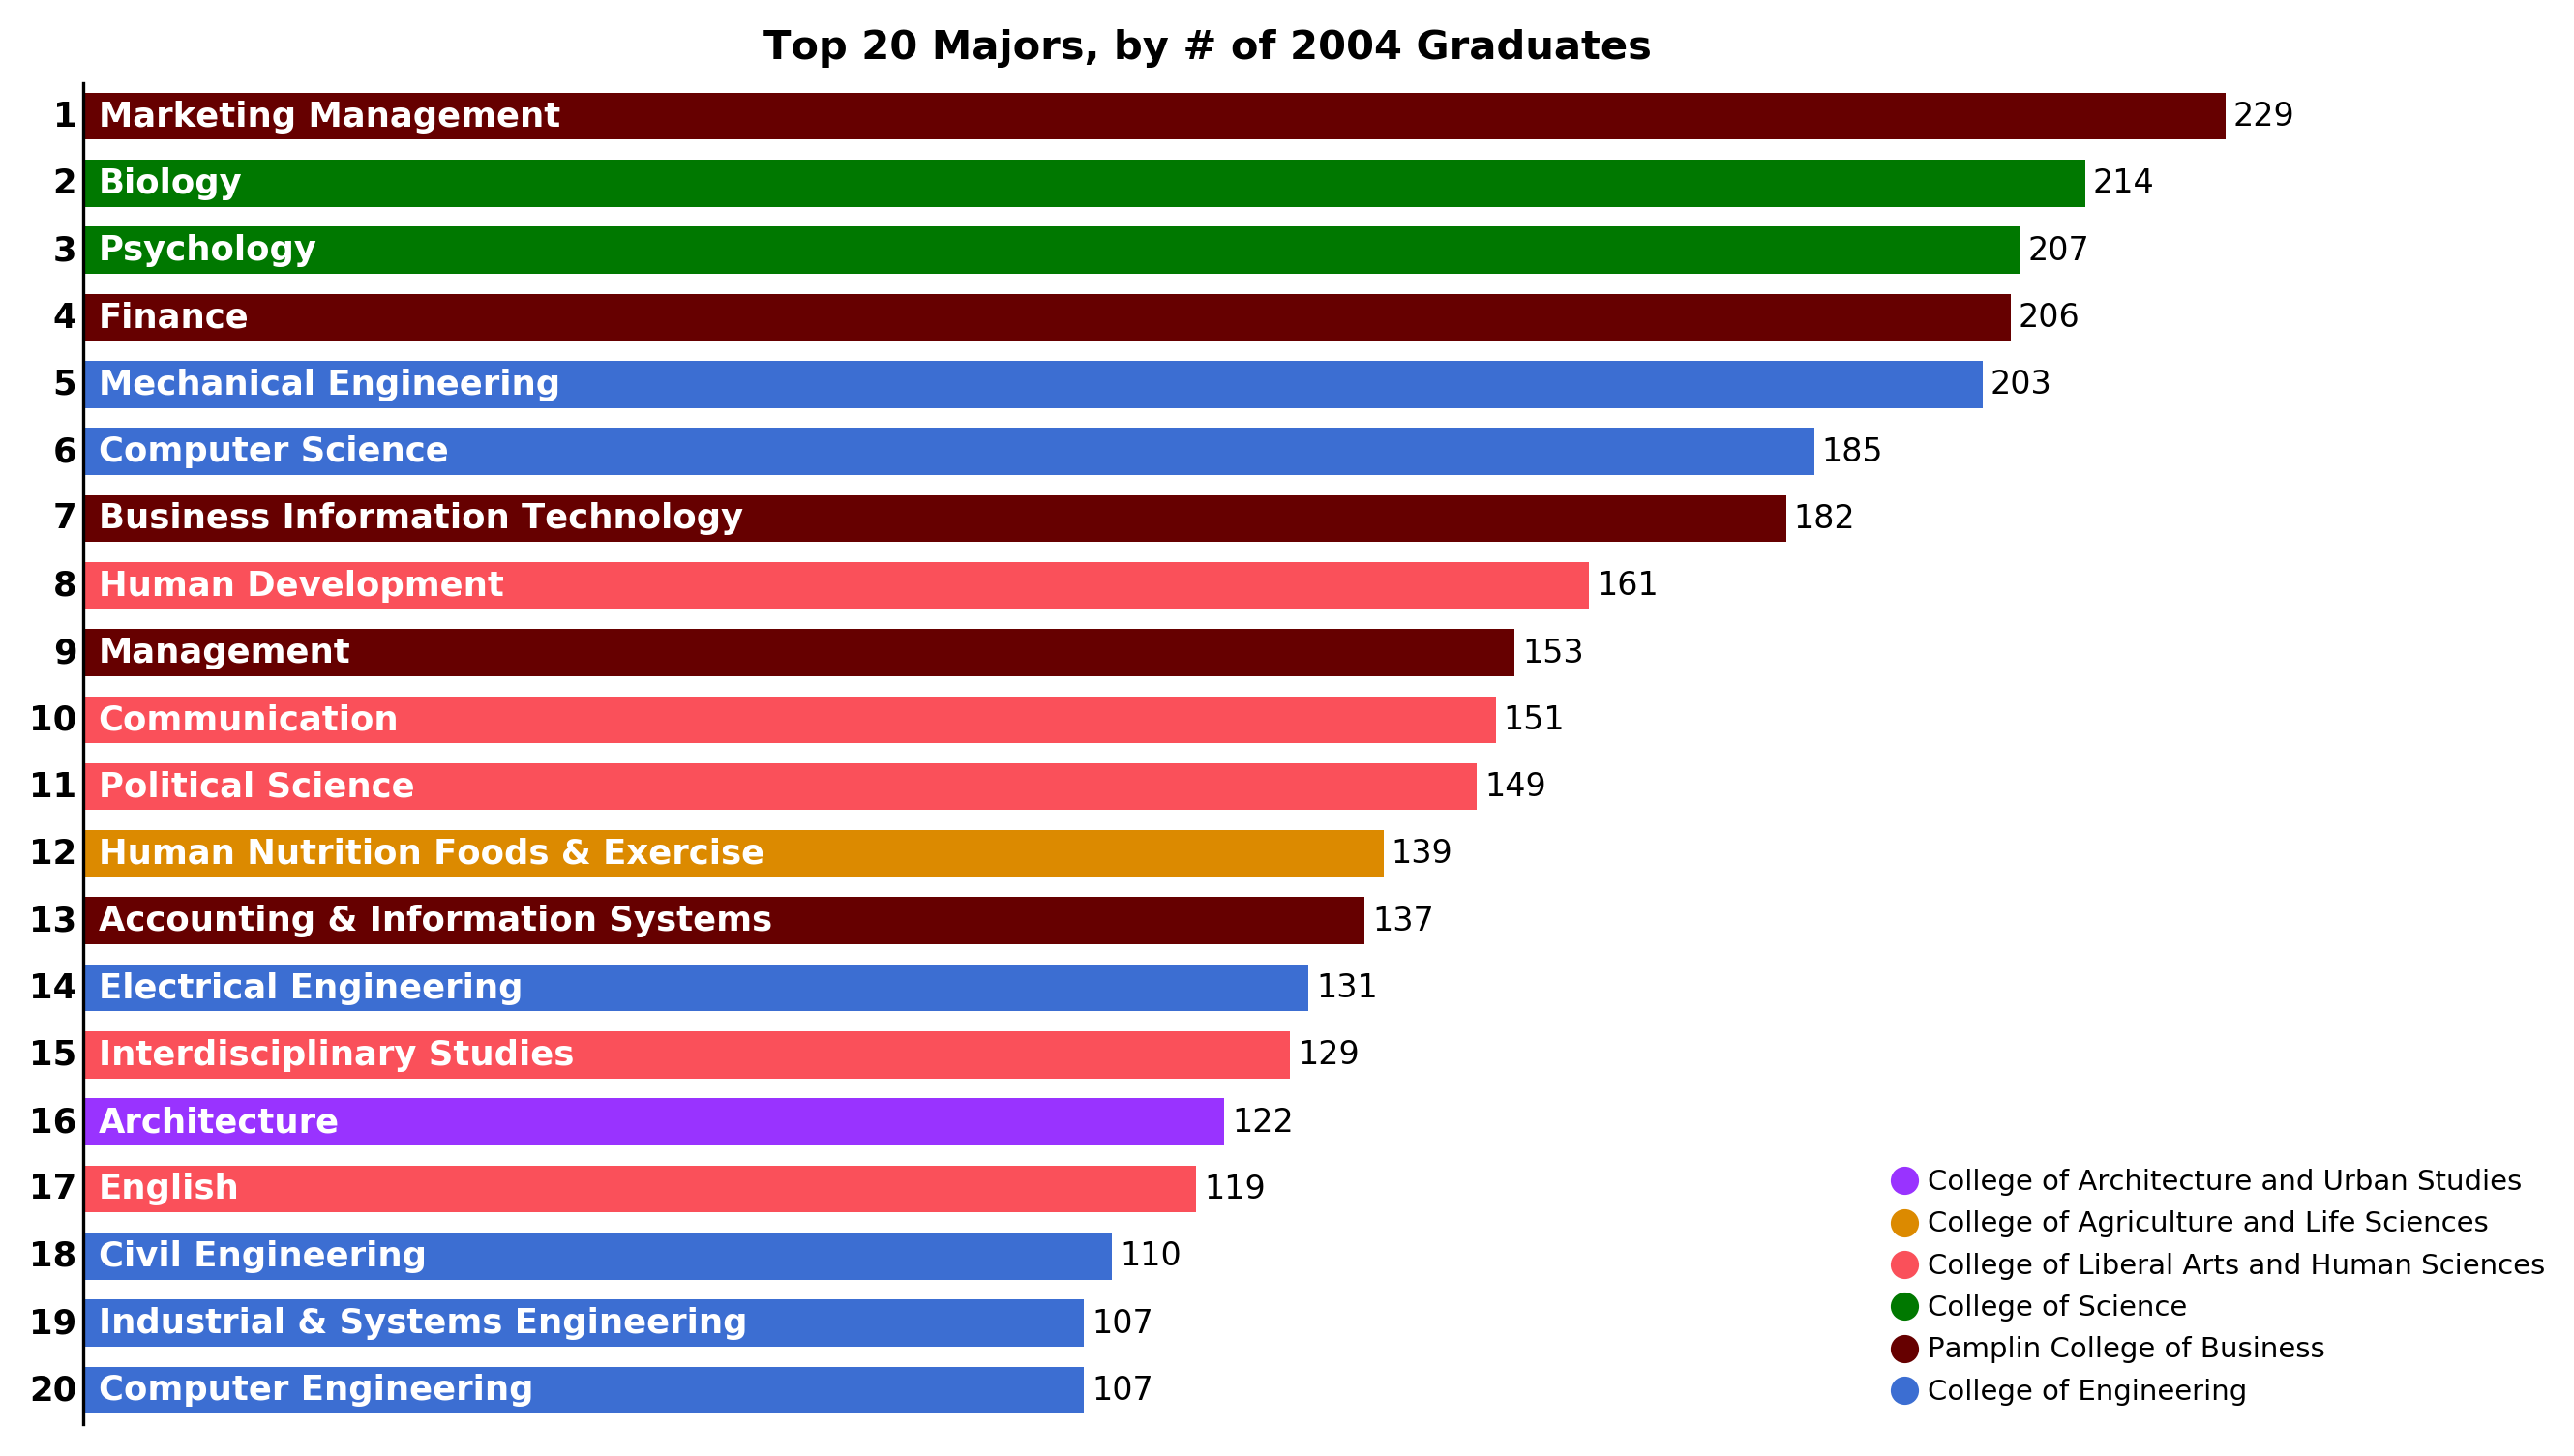

In [11]:
horizontal_bar_by_college('n_grads', 2004)
plt.title('Top 20 Majors, by # of 2004 Graduates', fontsize=10, weight='bold')

We can see from this graph that Mechanical Engineering, Business Information Technology, and Human Nutrition Foods & Excercise have all just about doubled in terms of total grads from 2004 to 2017. Marketing Management was surprisingly the most popular major of all in 2004. In 2017 it was the 4th most popular <i>business major</i>, and fell from 1st to 13th overall. We can also see a general rise in popularity for Engineering majors and a fall in popularity for Liberal Arts majors.

Let's get back to analyzing median salary, focusing on the the most recent salary numbers.

Text(0.5,1,'Top 20 Majors, by 2017 Median Starting Salary ($)')

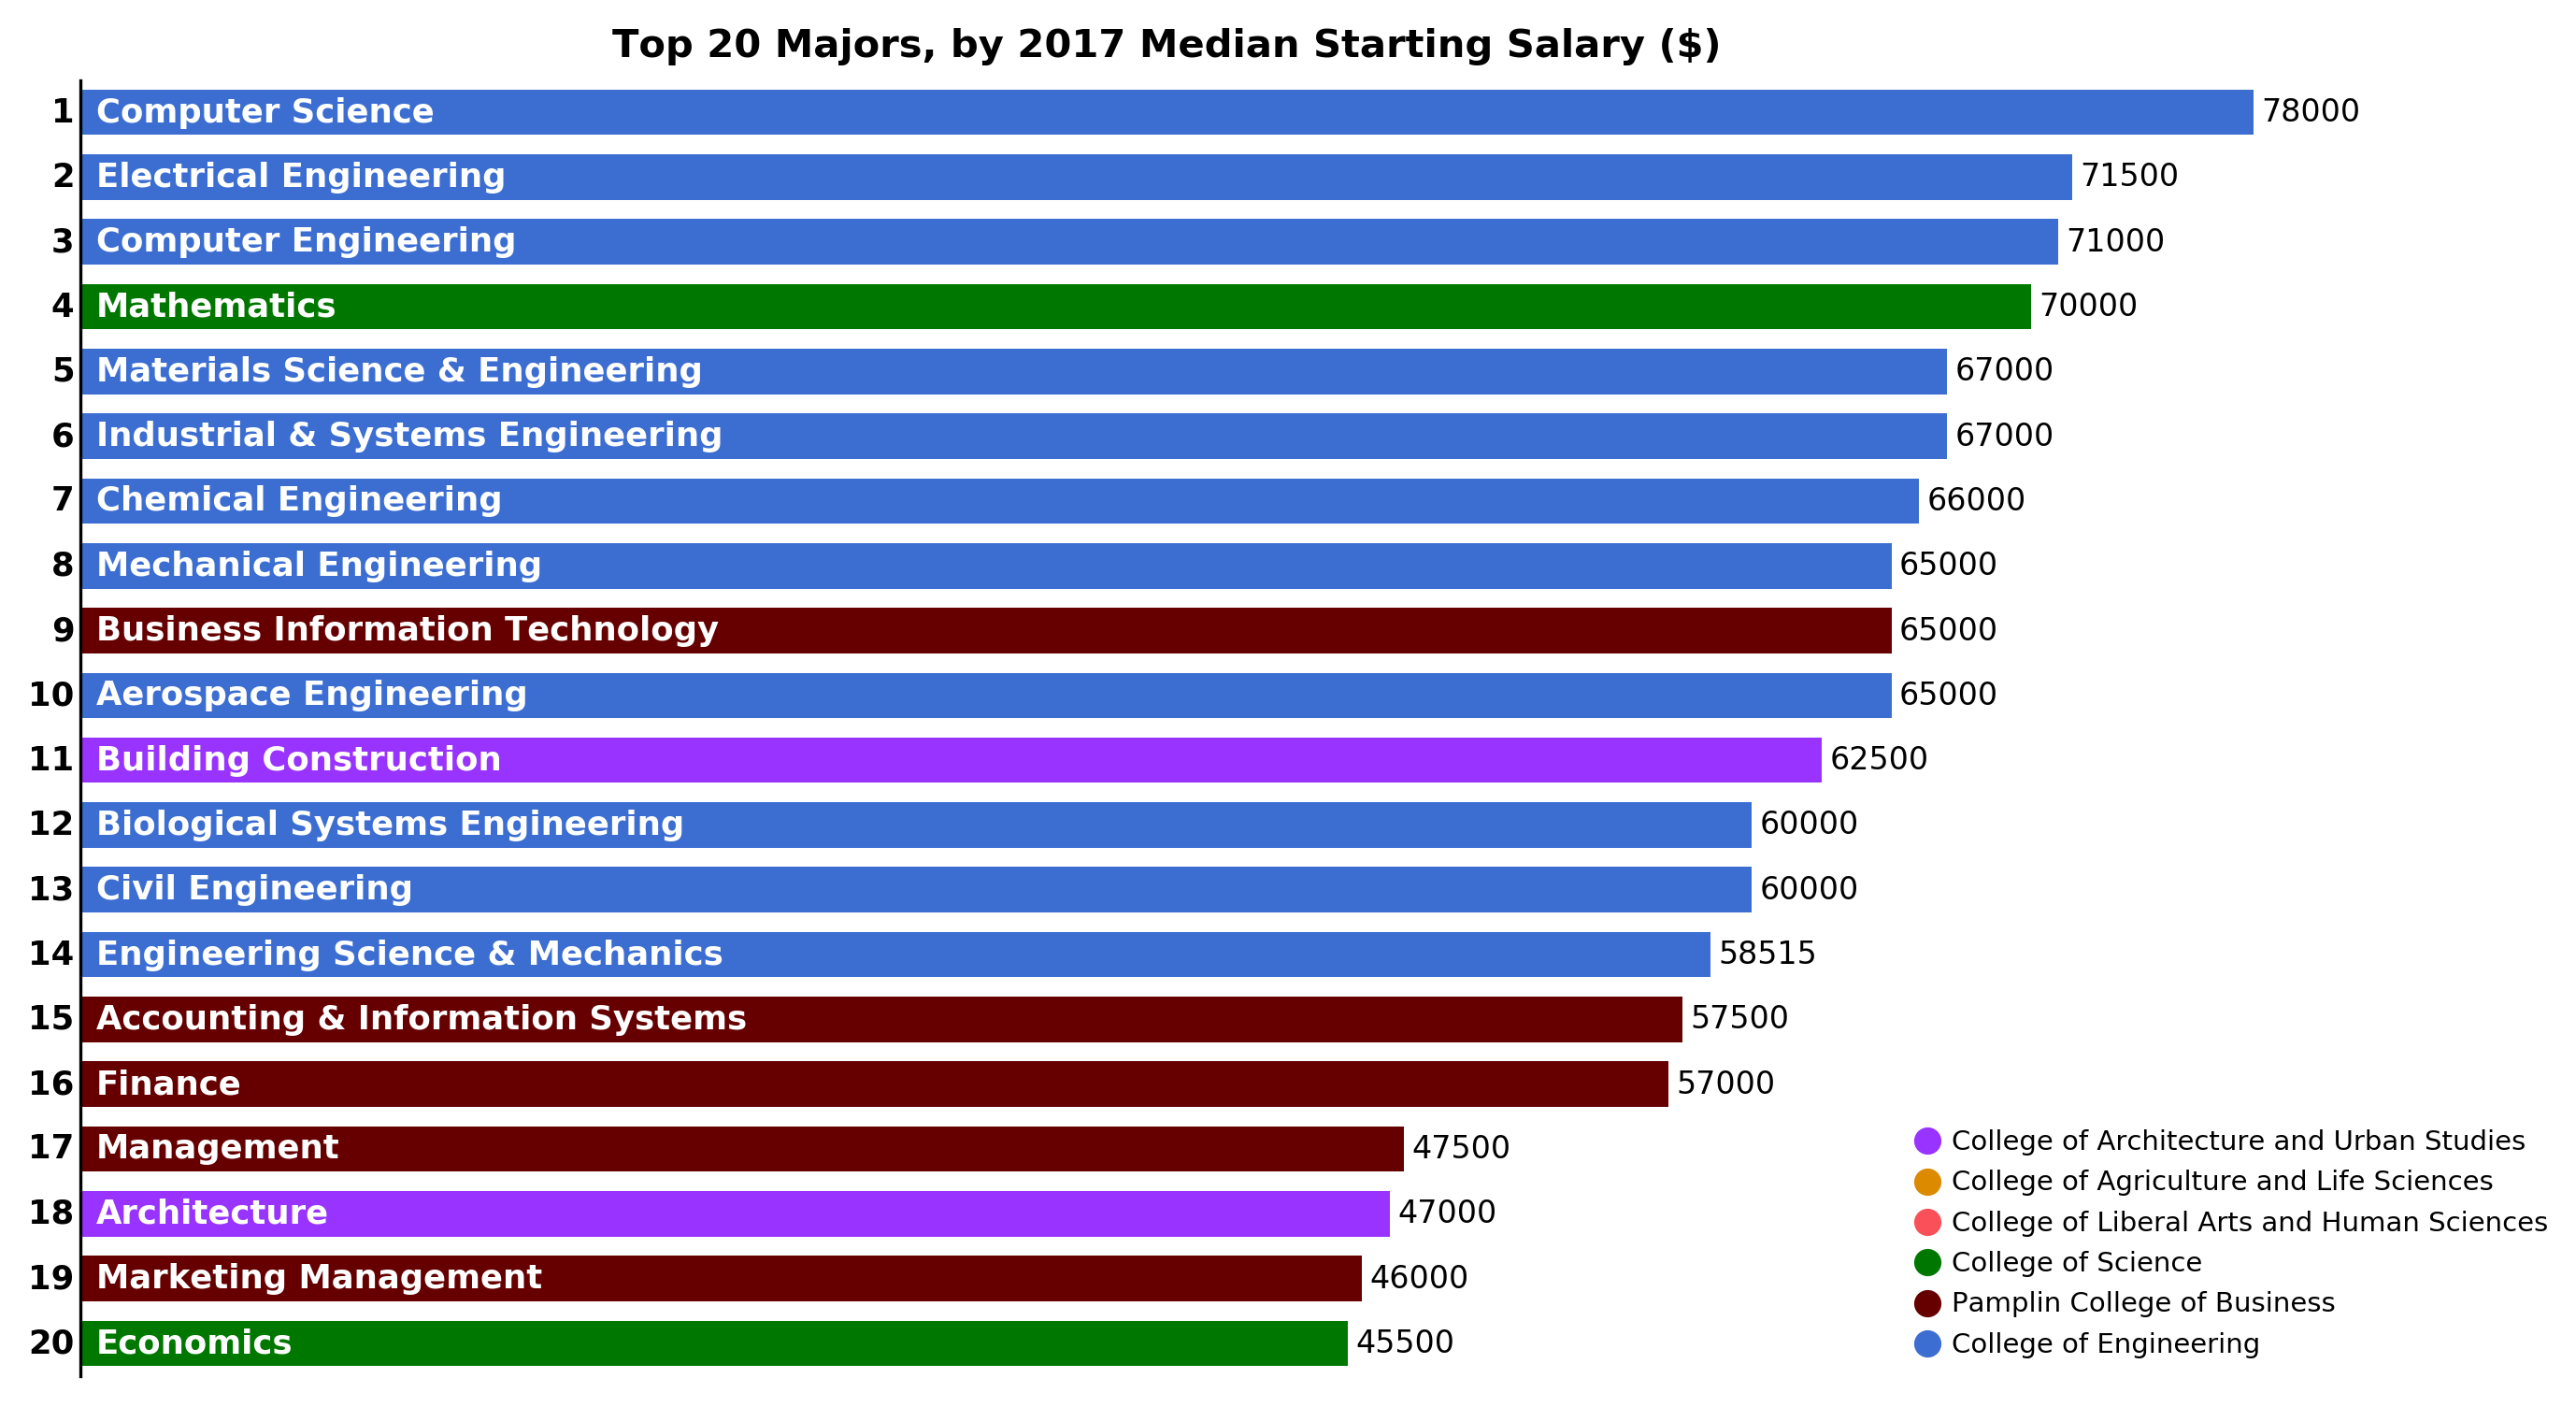

In [12]:
horizontal_bar_by_college('median_salary',2017)
plt.title('Top 20 Majors, by 2017 Median Starting Salary ($)', fontsize=10, weight='bold')

Here we can see just how dominant the College of Engineering is when it comes to starting salaries. 8 of the top 10 and 12 of the top 15 starting salaries* were Engineering majors. This graph shows how you can't go wrong with choosing to study Engineering at Virginia Tech.

*<b>Note:</b> Salaries from majors with less than 50 graduates were not included. 

Finally, let's take a look at the majors with the highest employment rate (at the time the survey was distributed) in 2017.

Text(0.5,1,'Top 20 Majors, by 2017 Employment Rate (%)')

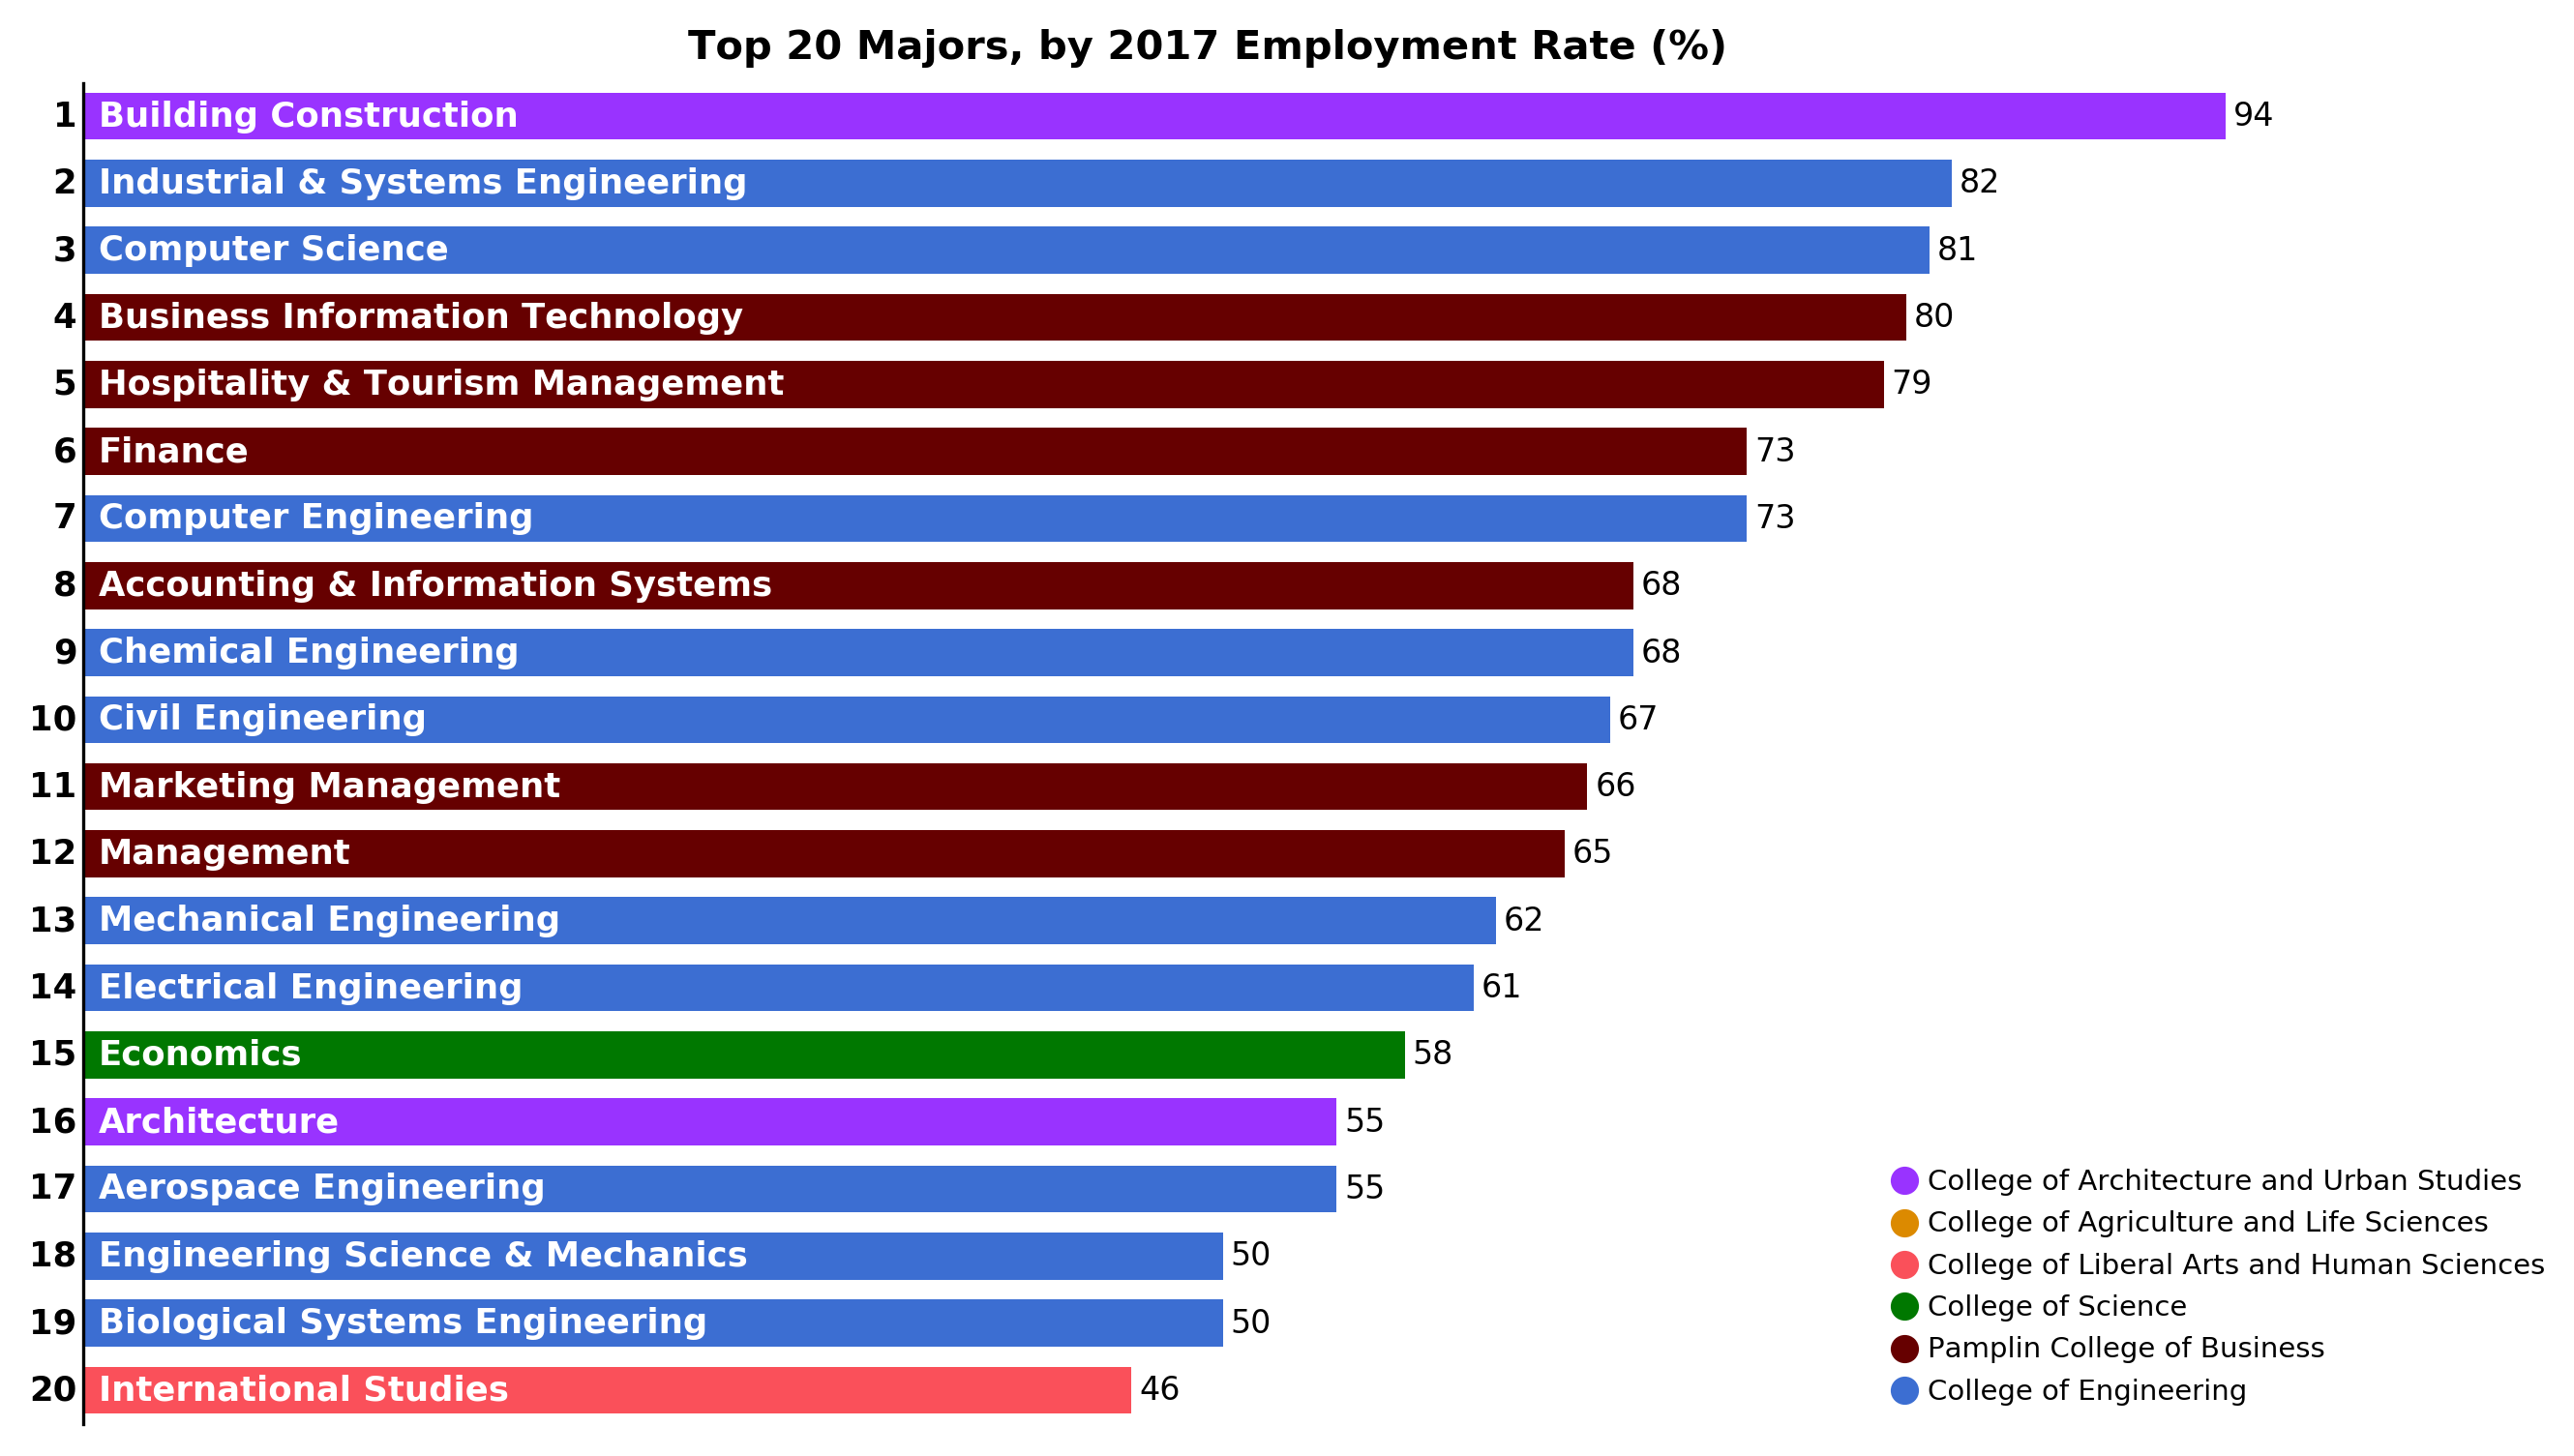

In [13]:
horizontal_bar_by_college('emp_rate',2017)
plt.title('Top 20 Majors, by 2017 Employment Rate (%)', fontsize=10, weight='bold')

Surprisingly, Building Construction ranks 1st when it comes to employment rate (at the time the survey was distributed). Unsurprisingly, engineering and business majors comprise of the next 13 highest employment rates. 

As far as career prospects go (accounting for starting salary and employment rate), engineering and business majors appear to be in a league of their own at the top. Since we have starting salary data for every year since 2004, let's take a deeper look into starting salary trends among these two colleges.

### Visualizing Starting Salary Trends
Let's define a function that plots starting salary data for majors in any given college, from 2004 to 2017, and compares these trends to the national average.

In [14]:
def plot_college_salaries(college):
    plt.style.use('seaborn')
    title = 'VT ' + college + ' Starting Salaries'
    college_df = all_years_reports(college)
    majors = college_df['major'].unique()
    majors_list = majors.tolist()
    chart_rows = math.ceil(len(majors_list)/4)
    fig = plt.figure(figsize=(14,chart_rows*5),dpi=350)
    plt.suptitle(college + ' Starting Salaries Trend', fontsize=18, fontname = 'Verdana', weight='bold', ha='center')
    for i, major in enumerate(majors_list):
        #Filter all year reports by a specific major 
        filtered_df = college_df[college_df['major']==major]
        year_df = filtered_df[filtered_df['year'] == 2017]
        year_df.reset_index(drop=True, inplace=True)
        get_val = year_df['n_grads'].mean()
        df = filtered_df
        ax = fig.add_subplot(chart_rows, 4, i+1)
        ax.plot(avg_sal_df['Year'], avg_sal_df['Salary'], label='average', c=(71/255, 0/255, 179/255), 
                marker='o', ls='--', ms=4, alpha = 0.5)
        ax.plot(df['year'], df['median_salary'], label=major, marker='o', c='g', ms=4)
        ax.plot(df['year'], df['salary_25'], label=major, lw=0.05, c='g', ms=4, alpha=0.5)
        ax.plot(df['year'], df['salary_75'], label=major, lw=0.05, c='g', ms=4, alpha=0.5)
        ax.fill_between(df['year'], df['salary_75'], df['salary_25'], color='g', alpha=0.1)
        ax.set_xlim(2004,2017)
        ax.set_ylim(5000,95000)
        ax.set_title(major, fontname= 'Verdana', fontsize=11)
        ax.yaxis.grid(linewidth=0.6)
        ax.tick_params(left=False, bottom=False)
        ax.set_xticks(np.arange(2006,2018,5))
        ax.grid(False)
        ax.yaxis.grid(linewidth=0.7)
        ax.tick_params(left=False, bottom=True)
        if (i in [0, 4, 8, 12]):
            ax.set_yticks(np.arange(10000, 95000, 10000))
            ax.set_ylabel('Starting Salary ($)', fontsize=12)
            ax.yaxis.set_ticklabels(['10K', '20K', '30K', '40K', '50K', '60K', '70K', '80K', '90K'])
            if i == 0: 
                custom_lines = [Line2D([0], [0], color='g', lw=2),
                                Line2D([0], [0], color='g', alpha = 0.2, lw=5),
                                Line2D([0], [0], color=(71/255, 0/255, 179/255), alpha=0.5, lw=2, linestyle='dashed')]
                ax.legend(custom_lines, ['Median Salary', 'Interquartile Range',
                                         'National Average'], loc='upper left')
        else:
            ax.yaxis.set_ticklabels([])
        plt.tight_layout(pad=0.4, w_pad=1.4, h_pad=2)

Let's now use our function to explore salary trends for the two colleges with the best career prospects: the College of Engineering and Pamplin College of Business. 

Some things to note:
* We only have median salary data for VT majors and average salary data nationally. Regardless, these are still useful to compare.
* Due to the volatility of small sample sizes, only years with 50 or more graduates are included.
* Data points for newer majors will only appear in recent years.
* Interquartile range does not appear for majors with smaller sample size.

We'll start by plotting Engineering majors.

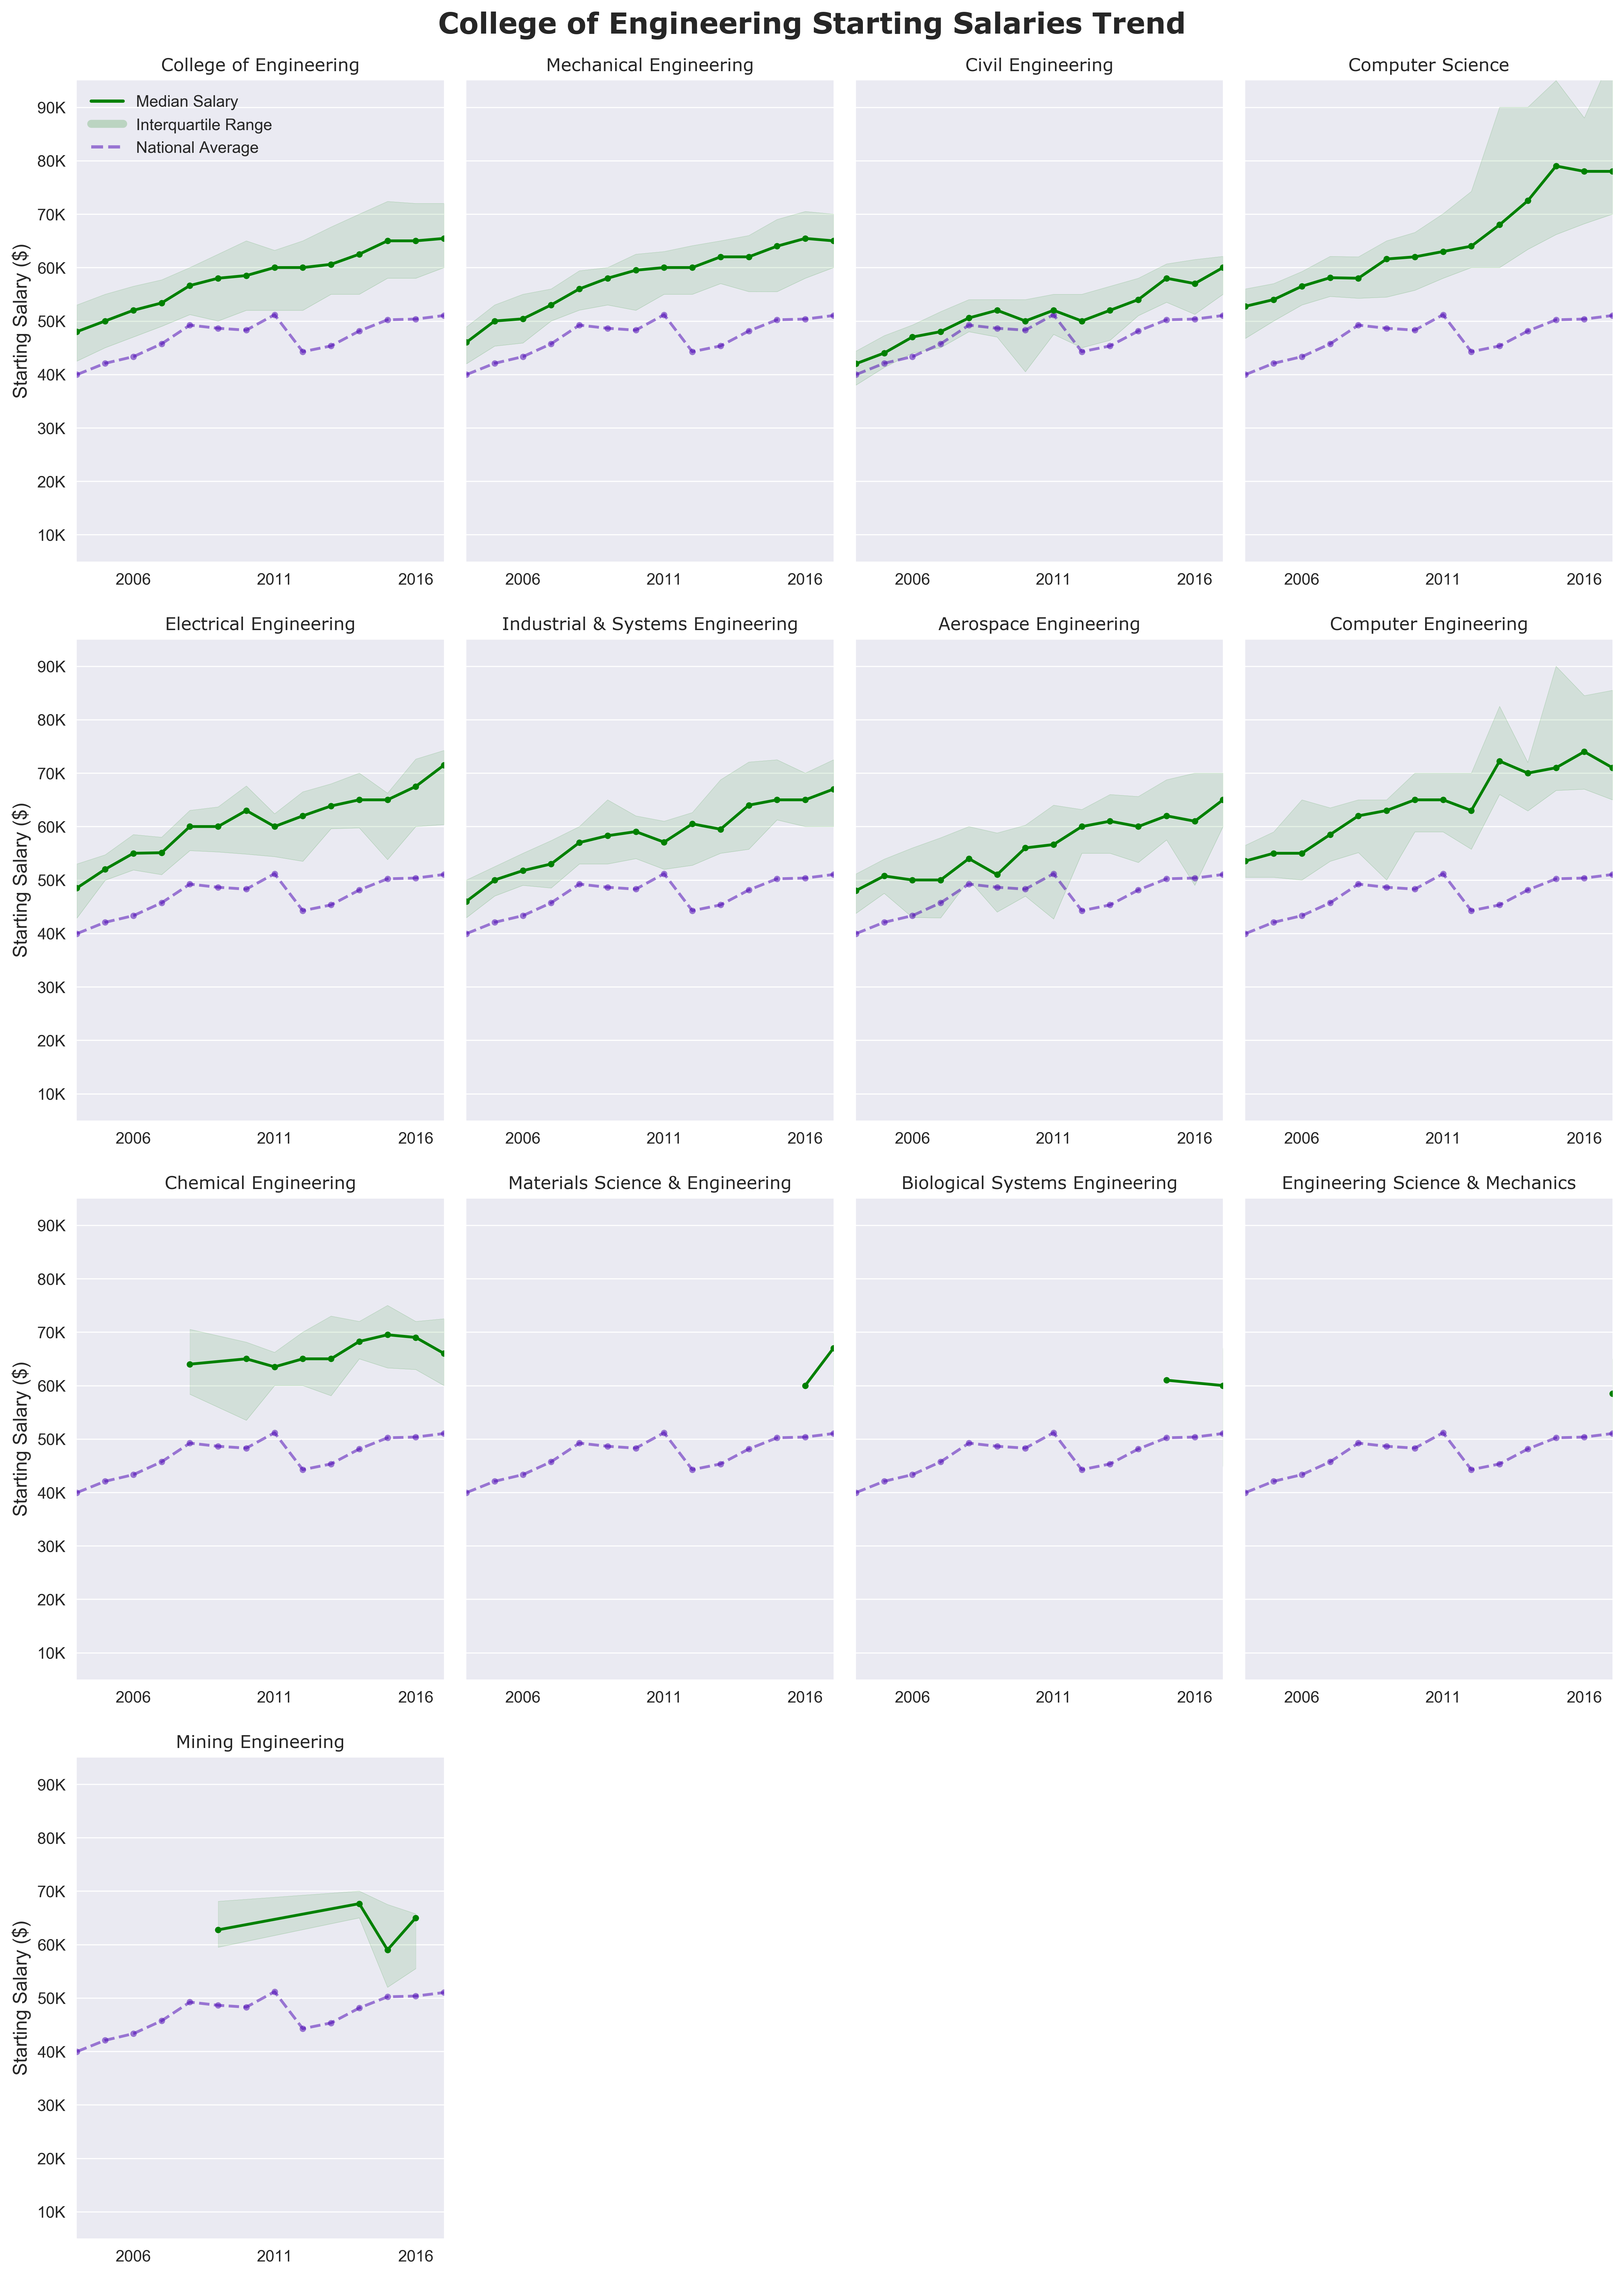

In [15]:
plot_college_salaries('College of Engineering')
plt.subplots_adjust(top=0.95) #adjust title position

Analysis:
* Computer Science and Computer Engineering are the two majors with huge earnings potential. I find it crazy how more than 25% of Computer Science majors are making more than $90k right out of college. 
* Starting salaries among Computer Science grads spiked from 2012-2015, possibly indicating a boom in this industry during those years. 
* Starting salaries for the College of Engineering as a whole seem to be climbing at a steady rate since 2004, indicating that VT engineering majors are increasing in demand, even during the recession.
* Starting salaries for every engineering major is significantly above the national average.

Let's now plot Business majors. 

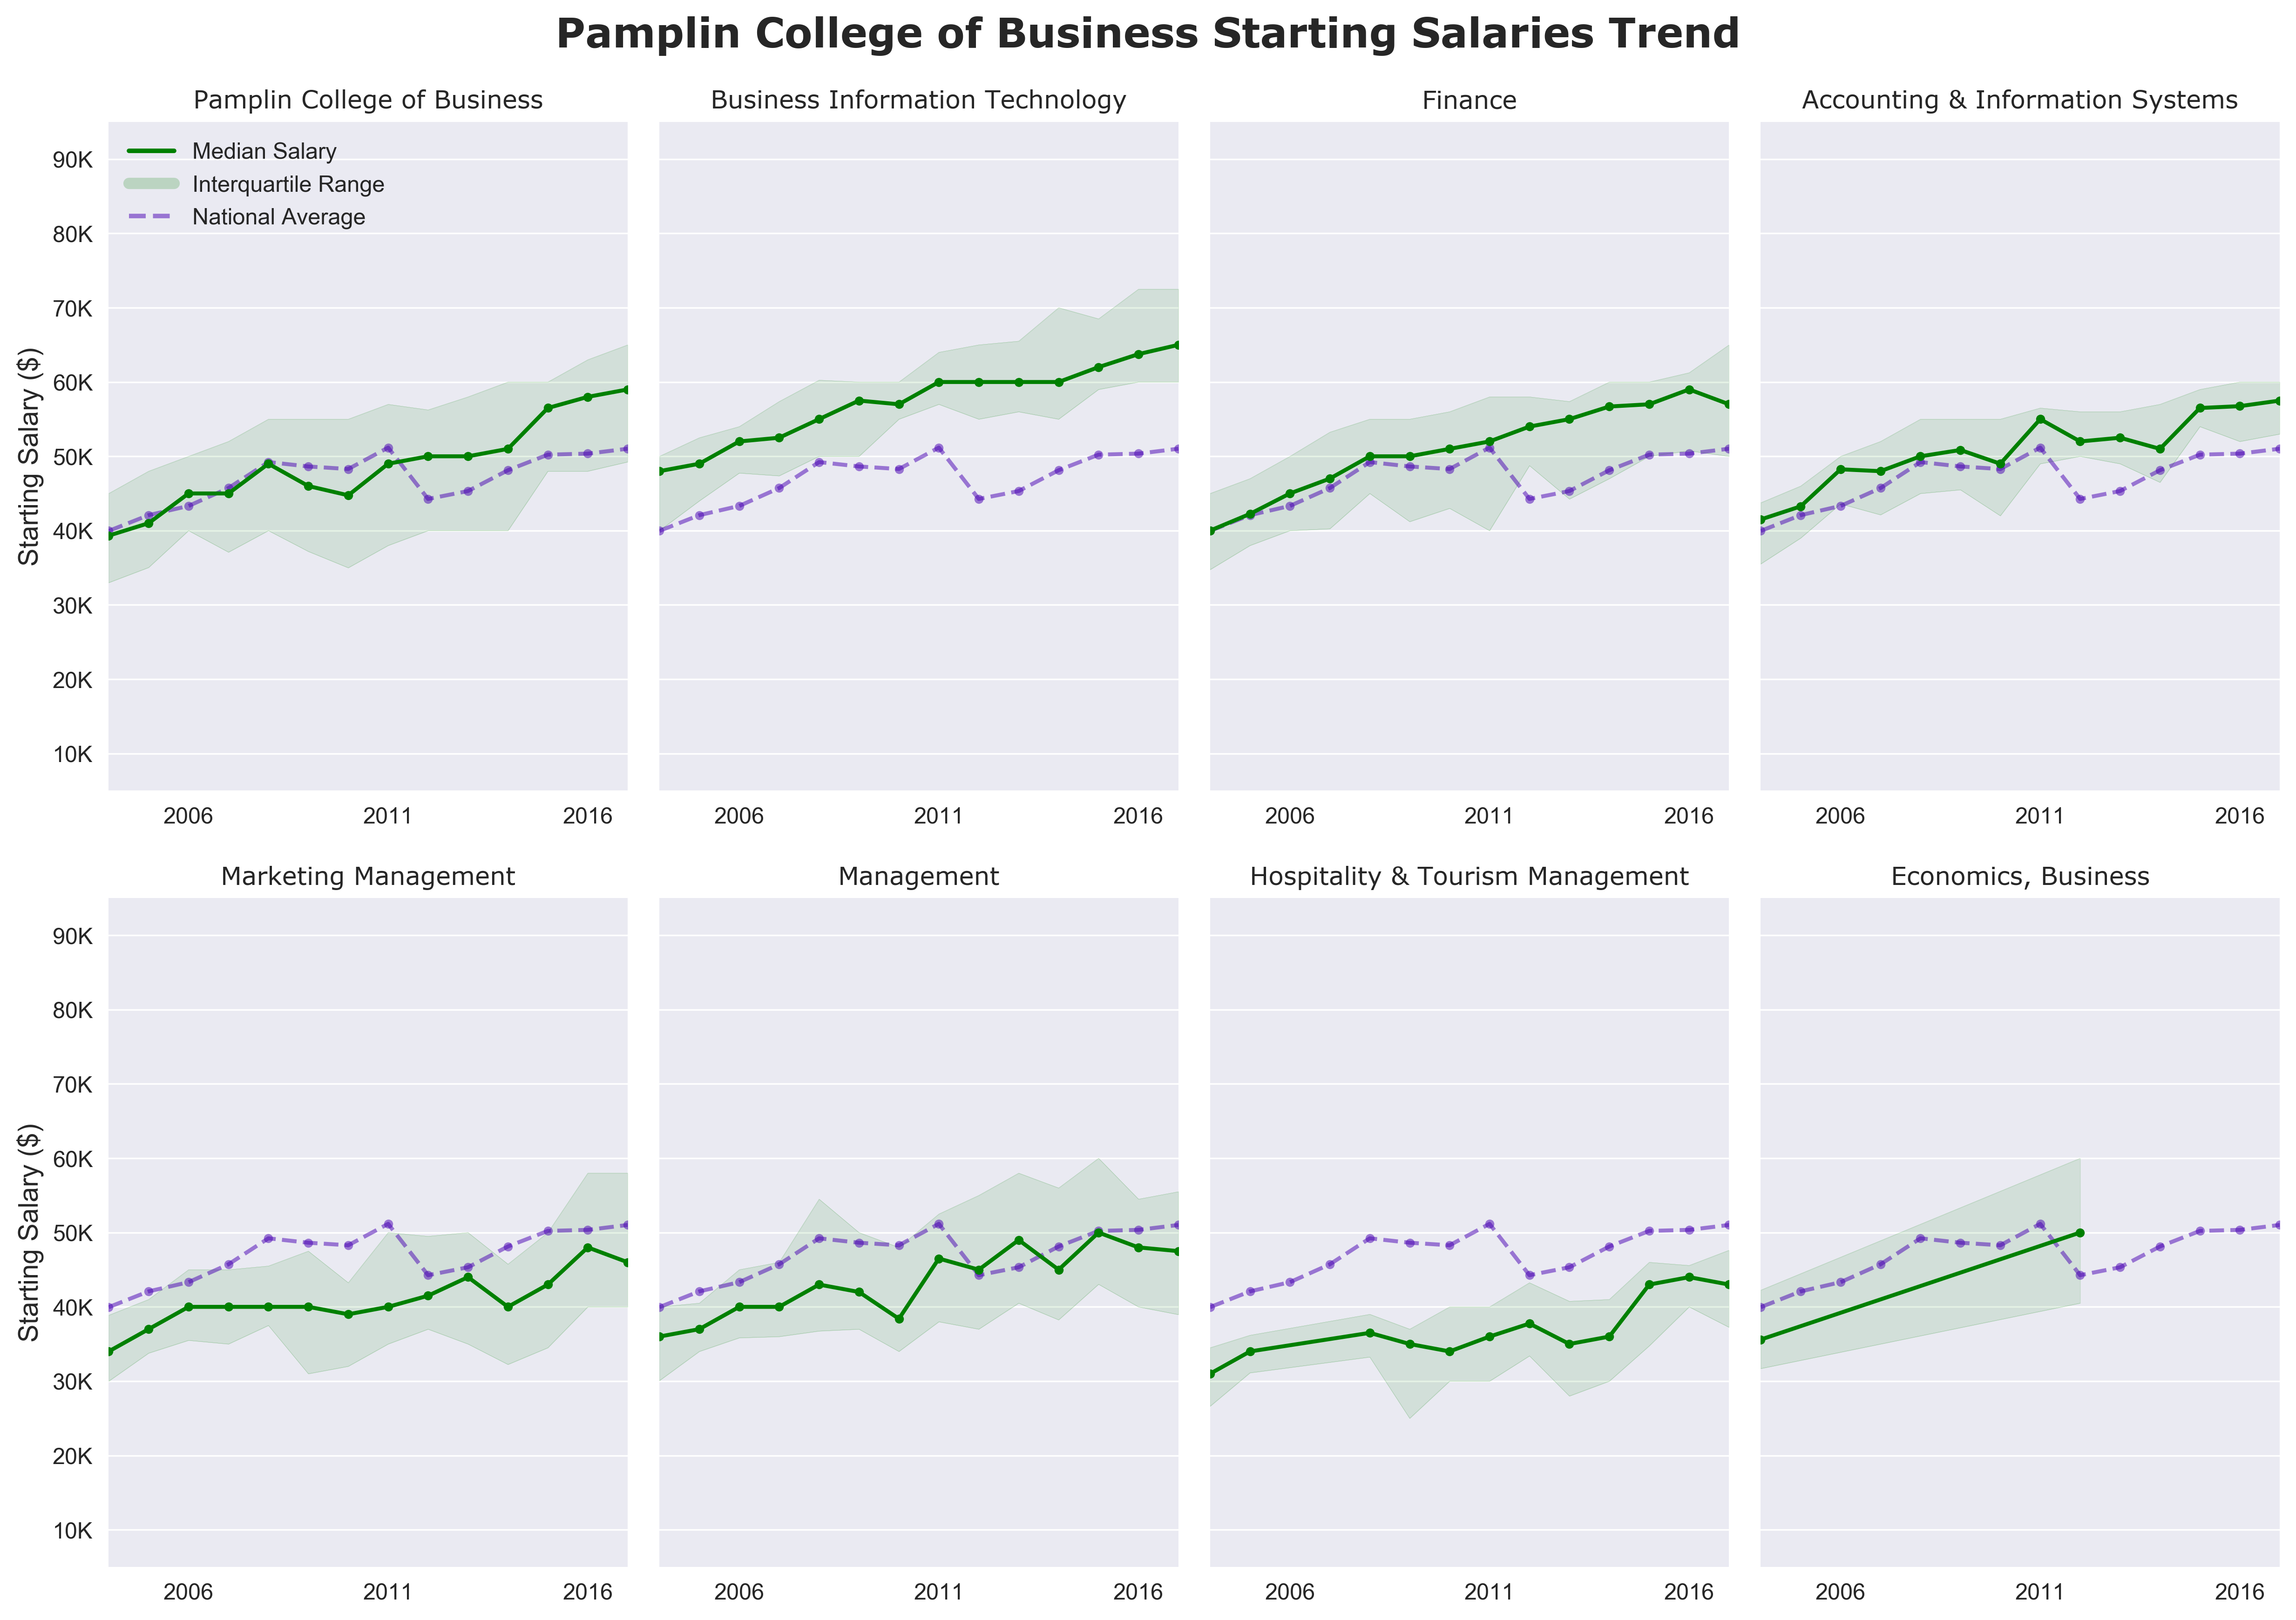

In [360]:
plot_college_salaries('Pamplin College of Business')
plt.subplots_adjust(top=0.915)

Analysis:
* Starting salaries for the Pamplin College of Business as a whole seemed to generally align with the national average up until 2015, where Pamplin salaries seemed to breakaway from the national trend line. 
* Business Information Technology (my major!) consistently has the highest median starting salary of any business major.
* In recent years, BIT, Finance, and Accounting have been the three business majors that outperform the national average. Management has pretty much aligned with the national average whereas Marketing and HTM have stayed below the average. 


## Conclusion
We can now see which Virginia Tech majors have the best career prospects, based on both starting salaries and employment rate. The College of Engineering dominates when it comes to starting salaries and both the College of Engineering and Pamplin College of Business dominate when it comes to employment rate right after graduation. 

Starting salaries for majors in the College of Engineering have been consistently strong, with a positive trend since 2004 that exceeds the national trend. Though starting salaries have not been equally as high among most Business majors, the starting salary trend for the Pamplin College of Business has been steadily increasing as well. 

### Possible Further Steps

* Plot employment rate trends from 2004-2017
* Adjust salary numbers for inflation
* Define a formula that creates a "power ranking" of all majors by year, based on starting salary and employment rate data
* Plot starting salary trends for all colleges on one chart
